In [0]:
import logging
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import tensorflow as tf
import lightgbm as lgb


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# Deep Learning for Time Series Forecasting

## Introduction

Time series forecasting has for long been an important area of research in many fields. The need to extrapolate information from time-indexed obersvations, as well as use it to predict dependant variables, has risen significantly with the surge in available data. Financial analysts rely on forecasts for understanding the ebb and flow of markets. Policy makers rely on forecasts to make decisions about production, purchases and allocation of resources. Retailers rely on supply and demand forecasts for planning and budgeting. In all these cases, inaccurate predictions can lead to: economic downfall, losses for both consumers and producers, social distress, or poor monetary policies.

Statisticians led the work on forecasting for a long while. Regression and autoregressive (AR) models conquered for as long as data was hard to find. These models, however, presented a naive view of time series, assuming that they're linear, when in reality, they are not. Today, both data and computing power have become readily available, shifting the focus of both academics and practitioners towards machine learning (ML) models for forecasting. 

While some have found significant success with classical ML solutions, others argue the need for deeper models, found in the study of deep learning (DL). Arguments backing ML rely on the relative simplicity of the models, compared to those found in DL. They also require less computing power, and hyperparameter tuning is generally simpler. Deep models, on the other hand, are great at modeling complex, non-linear, and hidden relationships in data. 

In this first article on deep learning for time series data, we'll aim to answer the following question: Are deep models needed for time series forecasting? While the answer to this question can depend on your business's objectives, ressources and expertise, the goal is to understand, one, just how big of a step it is to go from naive statistical approaches to more powerful deep learning models, and two, if it's worth it. Subsequent posts will look into other applications of deep learning when working with time series data, such as, anomaly detection, explainability and scaling.

## Analysis Setup

### Computing Environment

All models will be trained and tested on a machine with 128 GB of memory and 32 cores, in a Databricks environment.

### Dataset

We'll be using the bike sharing demand dataset from Kaggle, which can be found [here](https://www.kaggle.com/c/bike-sharing-demand/data#). It spans two years, is sampled every hour, and is setup such that the first twenty days of each month are used as the training set, while the last ten are used for testing. Our **forecasting goal** will be to predict the number of bikes rented at every hour i.e. the **count** column. 

As with any analysis, we can start by getting a high level understanding of our data.

In [0]:
dataset = pd.read_csv('/dbfs/FileStore/akhanafer/bikeSharingDemandData/train.csv', header=0, parse_dates=[0], index_col=0,).drop(['casual','registered'],axis=1)
dataset.index = pd.to_datetime(dataset.index).to_period('h')
dataset.dtypes

Out[3]: season int64
holiday int64
workingday int64
weather int64
temp float64
atemp float64
humidity int64
windspeed float64
count int64
dtype: object

We know from the dataset's description that the columns season, holiday, workingday and weather are categorical variables, so the first thing we'll do is change their type

In [0]:
dataset[['season', 'holiday', 'workingday', 'weather']] = dataset[['season', 'holiday', 'workingday', 'weather']].astype('category')
dataset.dtypes

Out[4]: season category
holiday category
workingday category
weather category
temp float64
atemp float64
humidity int64
windspeed float64
count int64
dtype: object

With that taken care of, we can now get a feel for our data's dispersion

In [0]:
dataset.describe()

,temp,atemp,humidity,windspeed,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,191.574132
std,7.79159,8.474601,19.245033,8.164537,181.144454
min,0.82000,0.760000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,42.000000
50%,20.50000,24.240000,62.000000,12.998000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,284.000000
max,41.00000,45.455000,100.000000,56.996900,977.000000


The minimum value of zero for both humidity and windspeed is odd. It's likely that the values were very low, and as such rounded to zero. We can deal with this by either, predicting the windspeed using some machine learning model, or simply leaving it as is. For the purpose of this blog, we'll keep the zeroes and assume that these values were initially extremely low.

Next, we'll plot our series to discover any seasonality and trends.

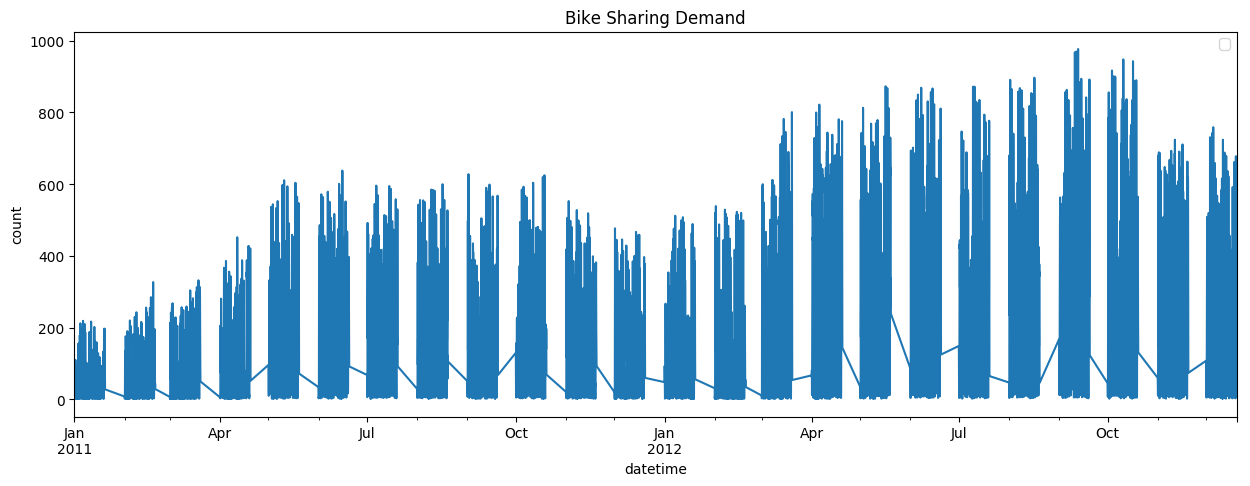

In [0]:
ax = dataset.plot.line(y='count',figsize=(15,5), title="Bike Sharing Demand", label='_')
ax.set_ylabel('count')
display()

There's clearly some yearly seasonality, with lower demand during the winter season (January through April) and higher demand in the summer. We can also zoom in on one month in particular to see if there's any seasonality on a daily or weekly level.

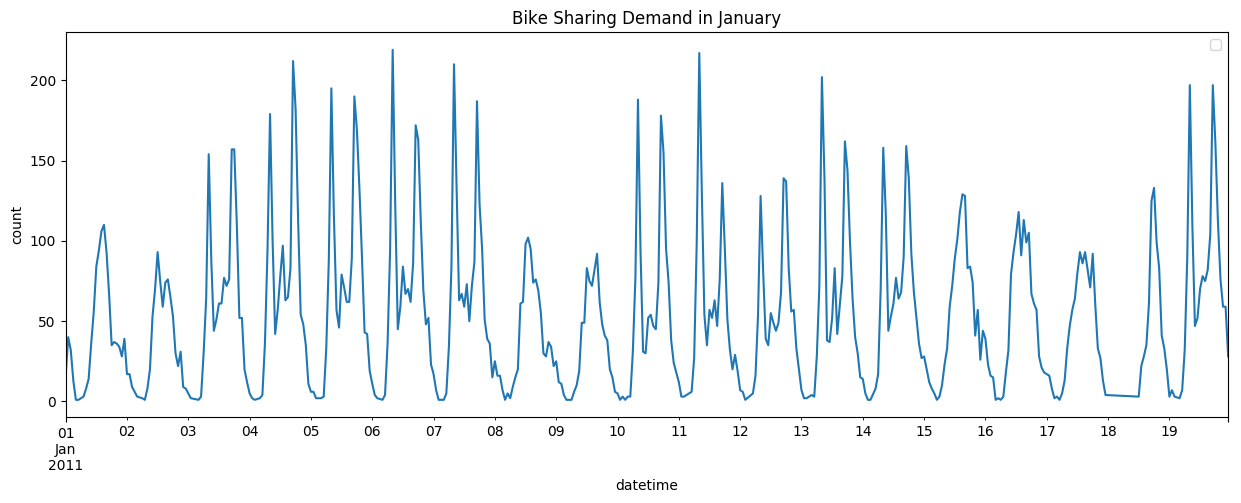

In [0]:
ax = dataset['2011-01'].plot.line(y='count',figsize=(15,5), title="Bike Sharing Demand in January", label='_')
ax.set_ylabel('count')
display()

Again we see some seasonality at the daily level, likely due to the difference in demand on a weekday as opposed to on a weekend, since some people bike to work. As for trends, we don't see any. This information will become important later on during our analysis of different models, as some models are better suited to work with seasonalities and trends, than others. 

Finally, we'll split our data to have 90% of it in the training set, and 10% in the testing set, leaving us with approximately 9800 training points, and 1000 testing points.

In [0]:
X_train, X_test = train_test_split(dataset, test_size=0.1, shuffle = False, stratify = None)
X_train = X_train.to_timestamp()
X_test = X_test.to_timestamp()
print(f'Training Set Size: {X_train.shape[0]}\nTesting Set Size: {X_test.shape[0]}')

Training Set Size: 9797
Testing Set Size: 1089

## Forecasting

We'll start our analysis by looking at some of the oldest models available for time series forecasting:
1. **ARIMA**: Model for univariate data that produces forecasts based solely on previous observations. External factors, such as weather, or the day of the week, aren't considered, nor are seasonalities. ARIMA takes as input three variables: Lag order, or *p*, degree of differencing, or *d*, and the order of the moving average, or *q*. What these variables mean is out of the scope of this article, but it's important to understand that they exist, and that they have significant impact on the results received.

2. **SARIMA**: SARIMA extends ARIMA. While it is still only suited for univariate data, this model includes extra terms that deal with seasonality. In addition to the three varibales needed for ARIMA, SARIMA takes as input four more: seasonal *P*, seasonal *D*, seasonal *Q*, and the number of observations per seasonal cycle, *m*. Once again, what these variables mean is out of the scope of this article.

3. **SARIMAX**: Also an extension of ARIMA, but this model works with multivariate datasets. As such, it factors into the predictions the impact of external features on our forecasts. Along with the six variables used by SARIMA, SARIMAX also expects an array of features.

Selecting the right parameters for these models requires significant statistical background, and a good understanding of autocorrelation, seasonality, trends and ACF plots. Luckily for us, their are libraries that can select the optimal values, based on our data. We'll be using the `auto_arima` function from the `pmdarima` python library to run these models against our dataset. The error metric we'll use to compare the different models will be the root mean squared logarithmic error (RMSLE). This is the metric used to judge the submissions to the Kaggle competition, where the leading results stand at an RMSLE of 0.33.

Let's see how the different models perform.

In [0]:
# ---- ARIMA ----
# Fit your model
%time model = pm.auto_arima(X_train['count'], seasonal=False)

CPU times: user 41.9 s, sys: 1min 3s, total: 1min 45s
Wall time: 19.4 s

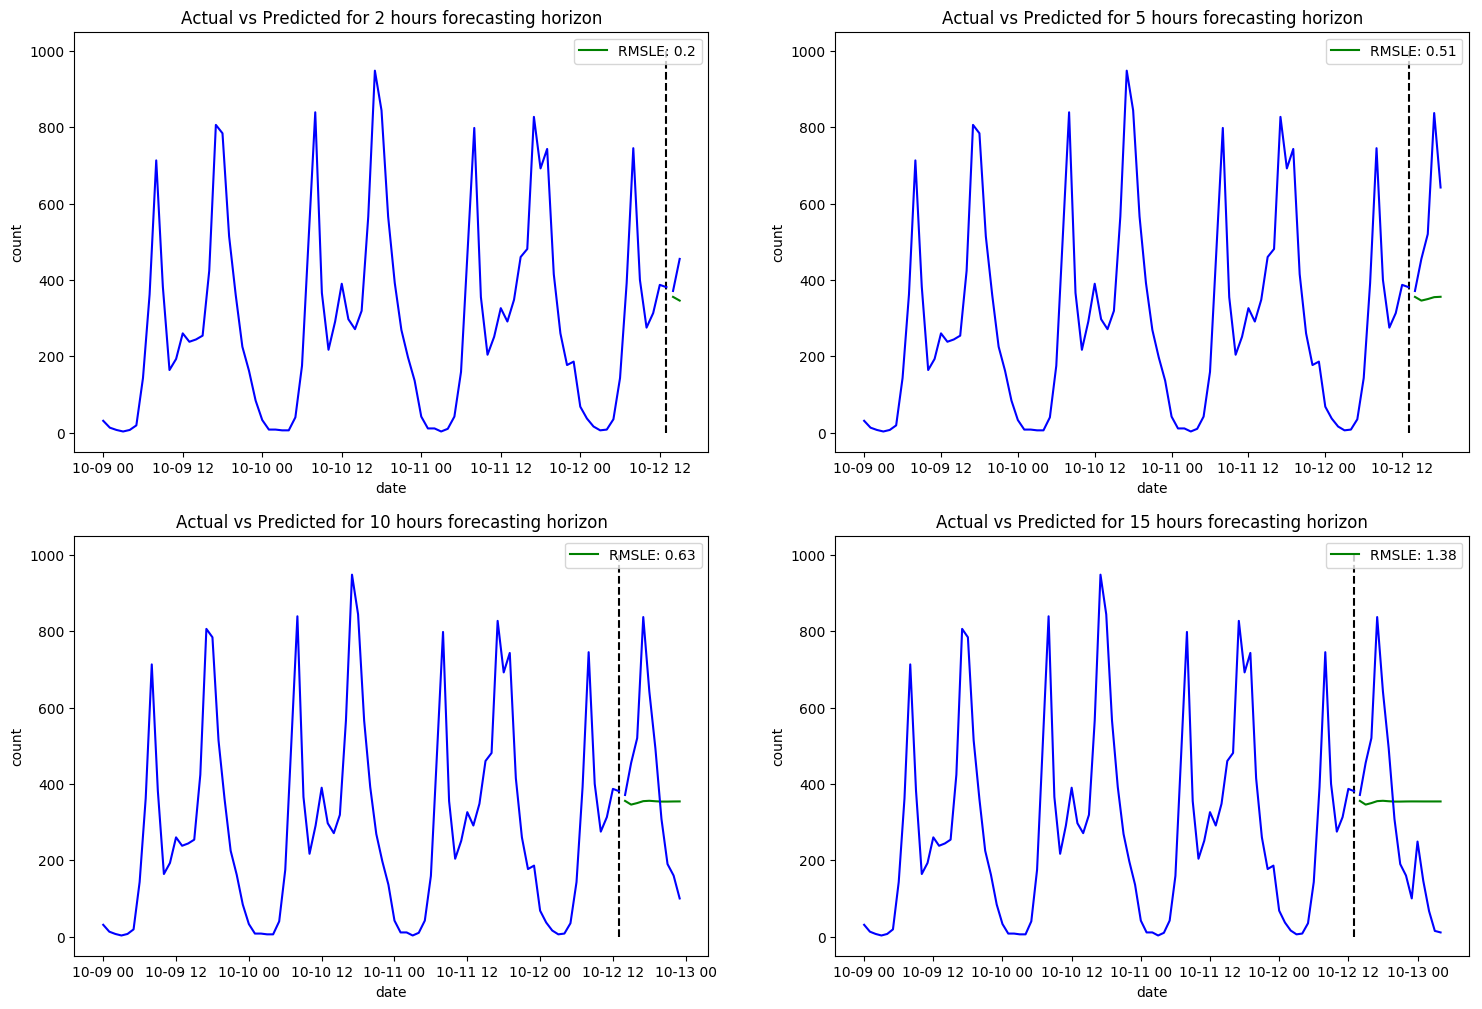

In [0]:
fig, ax_arr = plt.subplots(2,2, figsize=(18,12))
ax_arr = ax_arr.ravel()

for row, time_delta in enumerate([1, 4, 9, 14]):
  # make your forecasts
  forecasts = model.predict(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')]['count'].size)  # predict N steps into the future
  rmsle = np.round(np.sqrt(mean_squared_log_error(forecasts, X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit="h")]["count"])), 2)
  
  # Visualize the forecasts (blue=train, green=forecasts)
  ax_arr[row].plot(X_train['2012-10-09':].index, X_train['2012-10-09':]['count'], c='blue', label='_')
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index, forecasts, c='green', label=f'RMSLE: {rmsle}')
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index, X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')]['count'], c='blue',     label='_')
  ax_arr[row].vlines(x=X_train.index[-1], ymin=0,ymax=1000, linestyles='dashed')
  ax_arr[row].title.set_text(f'Actual vs Predicted for {time_delta + 1} hours forecasting horizon')
  ax_arr[row].set_ylabel('count')
  ax_arr[row].set_xlabel('date')
  ax_arr[row].legend()

display(ax_arr[0])

The above graphs show that ARIMA doesn't perform too well on our dataset, especially as we increase the forecasting horizon. In fact, it would have been naive of us to think it would perform any better than it has. Seasonality is a big factor when forcasting, but ARIMA doesn't include any seasonality terms, hence the poor performance. It also excludes any exterior factors that may be impacting the demand on bikes.

It's important to note, however, that the RMSLE for a forecasting horizon of two hours is relatively low. This indicates that for short-term forecasts, ARIMA can be pretty useful, especially if we take more time to tune hyperparameters and clean our dataset.

The obvious next step is to include seasonality terms in our model, so let's see how SARIMA performs.

In [0]:
# ---- SARIMA ----
# Fit your model
%time model = pm.auto_arima(X_train['count'], seasonal=True, m=12)

CPU times: user 2h 6min 59s, sys: 5h 16min 46s, total: 7h 23min 46s
Wall time: 19min 28s

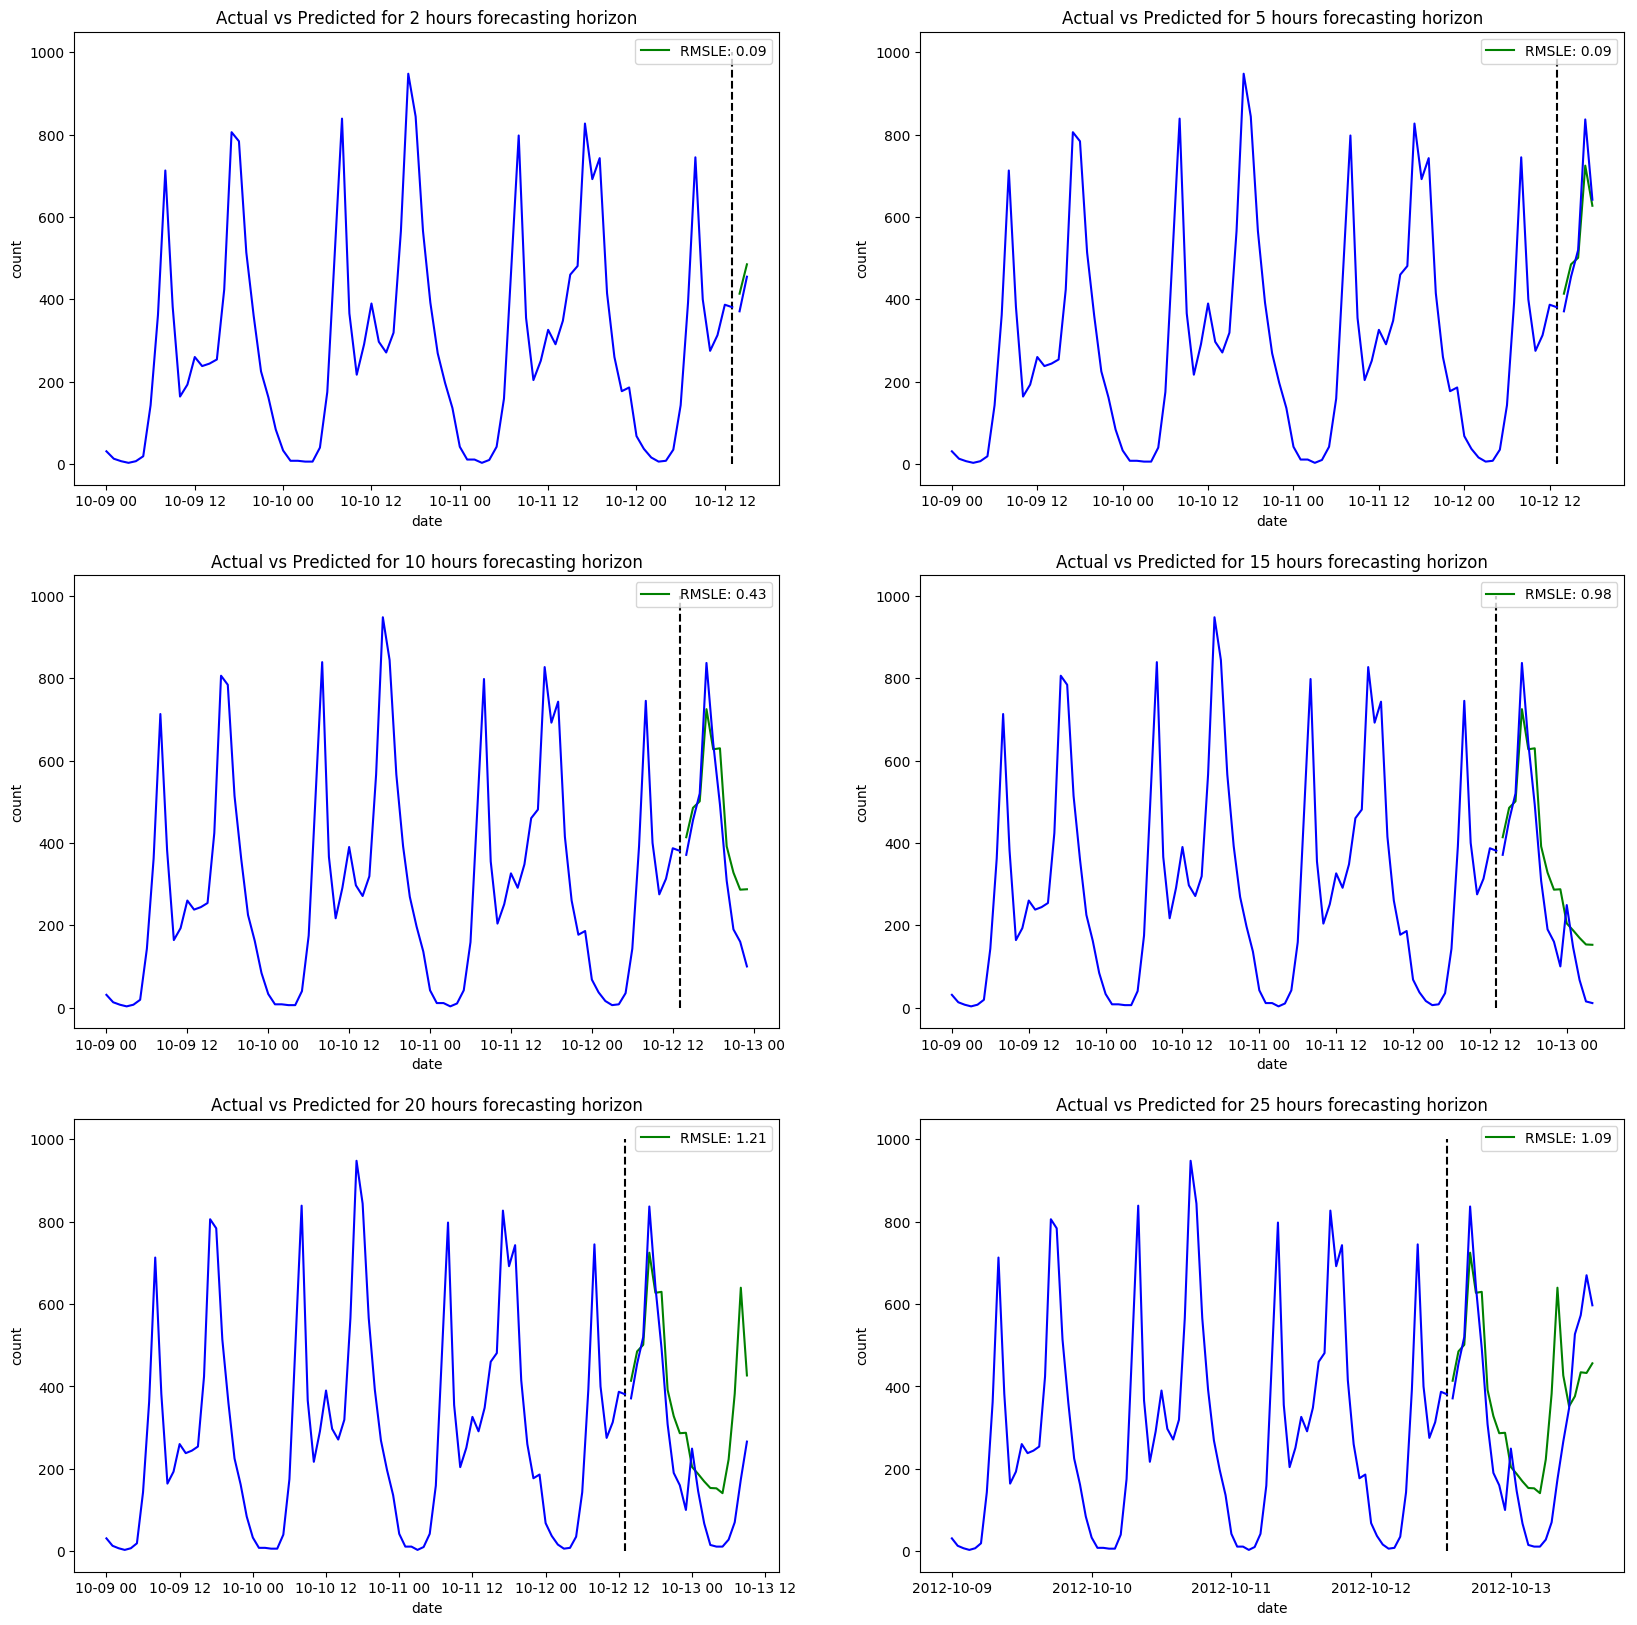

In [0]:
fig, ax_arr = plt.subplots(3,2, figsize=(20,20))
ax_arr = ax_arr.ravel()

for row, time_delta in enumerate([1, 4, 9, 14, 19, 24]):
  # make your forecasts
  forecasts = model.predict(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')]['count'].size)  # predict N steps into the future
  rmsle = np.round(np.sqrt(mean_squared_log_error(forecasts, X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit="h")]["count"])), 2)
  
  # Visualize the forecasts (blue=train, green=forecasts)
  ax_arr[row].plot(X_train['2012-10-09':].index, X_train['2012-10-09':]['count'], c='blue', label='_')
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index, forecasts, c='green', label=f'RMSLE: {rmsle}')
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index, X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')]['count'], c='blue',     label='_')
  ax_arr[row].vlines(x=X_train.index[-1], ymin=0,ymax=1000, linestyles='dashed')
  ax_arr[row].title.set_text(f'Actual vs Predicted for {time_delta + 1} hours forecasting horizon')
  ax_arr[row].set_ylabel('count')
  ax_arr[row].set_xlabel('date')
  ax_arr[row].legend()

display(ax_arr[0])

Definitely an improvment once we consider the seasonality in our data. Notice however, the much longer training time compared to ARIMA. Whereas it took only 20 seconds to fit our ARIMA model, the new seasonality terms have increased our training time significantly, to a total of twenty minutes. Considering our dataset is relatively small, this can become an issue if your goal is to scale. In terms of forecasting, this model seems to deal better with longer forecasting horizons, but still not convincing. The RMSLE gets higher as we pass the five hour mark.

You'll notice also that we had to pass the number of observations per seasonal cycle (*m*) to the `auto_arima` function, since it isn't a parameter it can learn on its own. This adds an extra layer of complexity to the model, since setting the right *m* will need a good understanding of line plots, and how to spot seasonal cycles.

The final step, before moving on to a different class of algorithms, is to see how well we can forecast if we add extra features to our SARIMA model. As aforementioned, The SARIMAX model takes an extra paramter *X*, which is an array of all the features you want to feed your model.

In [0]:
# ---- SARIMAX ----
# Fit your model
%time model = pm.auto_arima(y=X_train['count'], X=X_train.drop('count',axis=1), seasonal=True, m=12)

CPU times: user 8h 2min 37s, sys: 21h 25min 29s, total: 1d 5h 28min 6s
Wall time: 1h 9min 12s

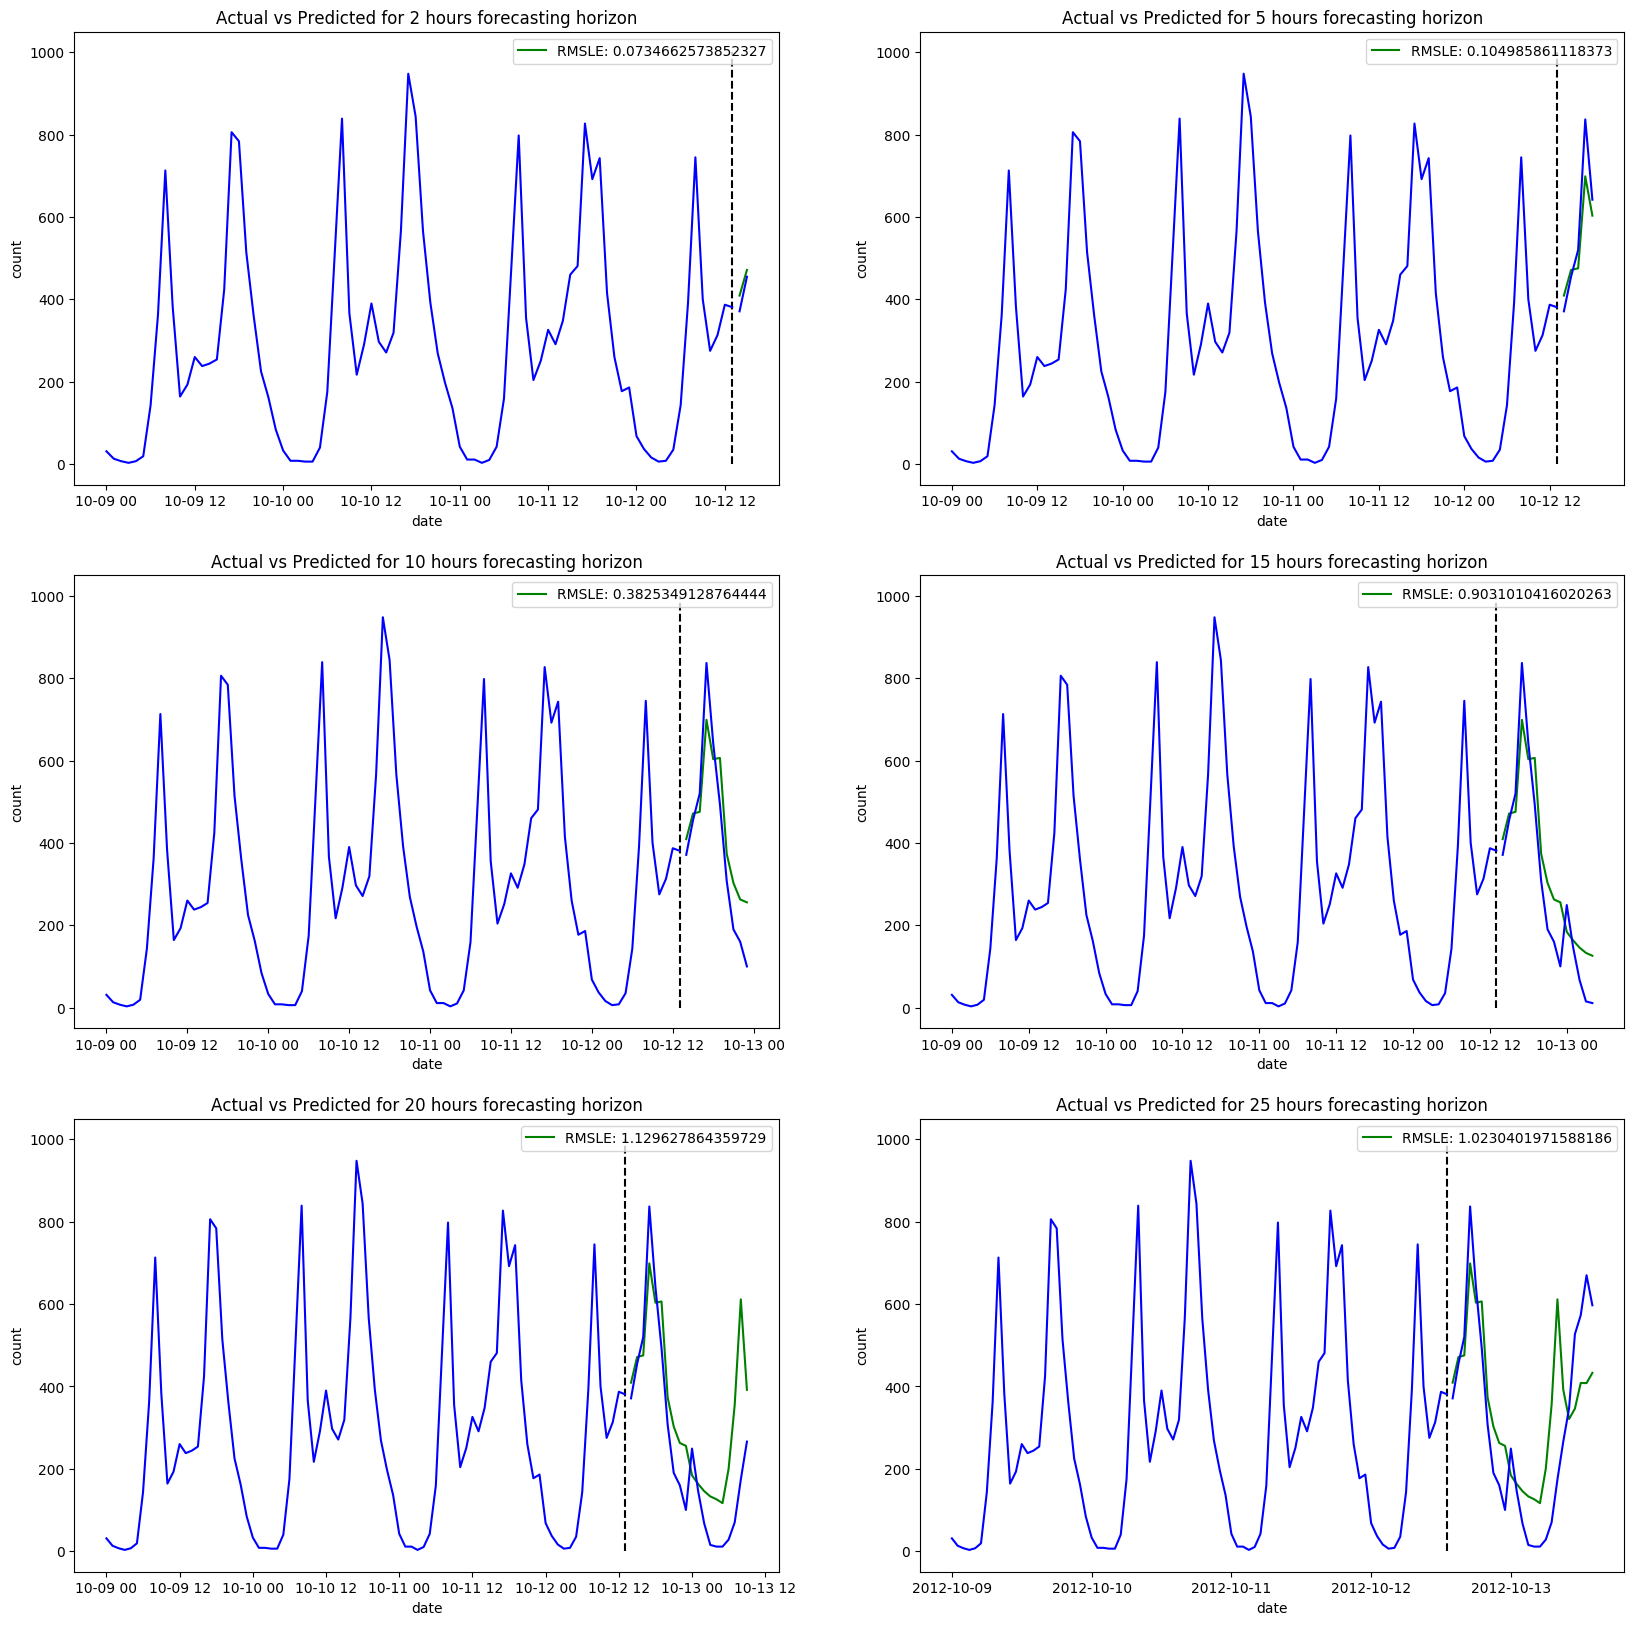

In [0]:
fig, ax_arr = plt.subplots(3,2, figsize=(20,20))
ax_arr = ax_arr.ravel()

for row, time_delta in enumerate([1, 4, 9, 14, 19, 24]):
  # make your forecasts
  X = X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].drop('count',axis=1)
  forecasts = model.predict(n_periods=X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')]['count'].size, X=X)  # predict N steps into the future
  rmsle = np.sqrt(mean_squared_log_error(forecasts, X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit="h")]["count"]))
  
  # Visualize the forecasts (blue=train, green=forecasts)
  ax_arr[row].plot(X_train['2012-10-09':].index, X_train['2012-10-09':]['count'], c='blue', label='_')
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index, forecasts, c='green', label=f'RMSLE: {rmsle}')
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index, X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')]['count'], c='blue',     label='_')
  ax_arr[row].vlines(x=X_train.index[-1], ymin=0,ymax=1000, linestyles='dashed')
  ax_arr[row].title.set_text(f'Actual vs Predicted for {time_delta + 1} hours forecasting horizon')
  ax_arr[row].set_ylabel('count')
  ax_arr[row].set_xlabel('date')
  ax_arr[row].legend()

display(ax_arr[0])

Immediately we notice a huge blow in performance, with the addition of new features increasing our training time to a whole hour and thirty minutes. Again, considering how small our training set is -- compared to how large they normally are for large organizations -- this increase in time is concerning. Even more concerning is the little reward we get back. Although we do see better results for both short and long term forecasting horizons, these improvements aren't significant.

The next model we'll look at is Prophet. Prophet is Facebook's time series forecasting solution, and is advertised as a model that is suitable for people who wish to produce forecasts, but aren't experts [1]. Facebook also claims that their solution is designed to handle a wide variety of forecasting problems [1]. We'll put these claims to the test by using Prophet on our own dataset. Before doing so, let's have a quick look at how the model is built:

$$y(t) = g(t) + s(t) + h(t) + E$$

Where *g(t)* is the trend function which models non-periodic changes in the value of the time series, *s(t)* represents periodic changes (e.g., weekly and yearly seasonality), and *h(t)* represents the effects of holidays which occur on potentially irregular schedules over one or more days [1]. The paper on Prophet also mentions a *Z(t)*, which is an optional matrix of other features we wish to add to our model.

In [0]:
# Prophet Multivariate
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',n_changepoints=1)

model.add_regressor('temp', standardize=True)
model.add_regressor('atemp', standardize=True)
model.add_regressor('humidity', standardize=True)
model.add_regressor('windspeed', standardize=True)


%time model.fit(X_train.reset_index().rename(columns={'datetime':'ds', 'count':'y'}))

CPU times: user 492 ms, sys: 0 ns, total: 492 ms
Wall time: 491 ms
Out[90]: <prophet.forecaster.Prophet at 0x7f291dd78450>

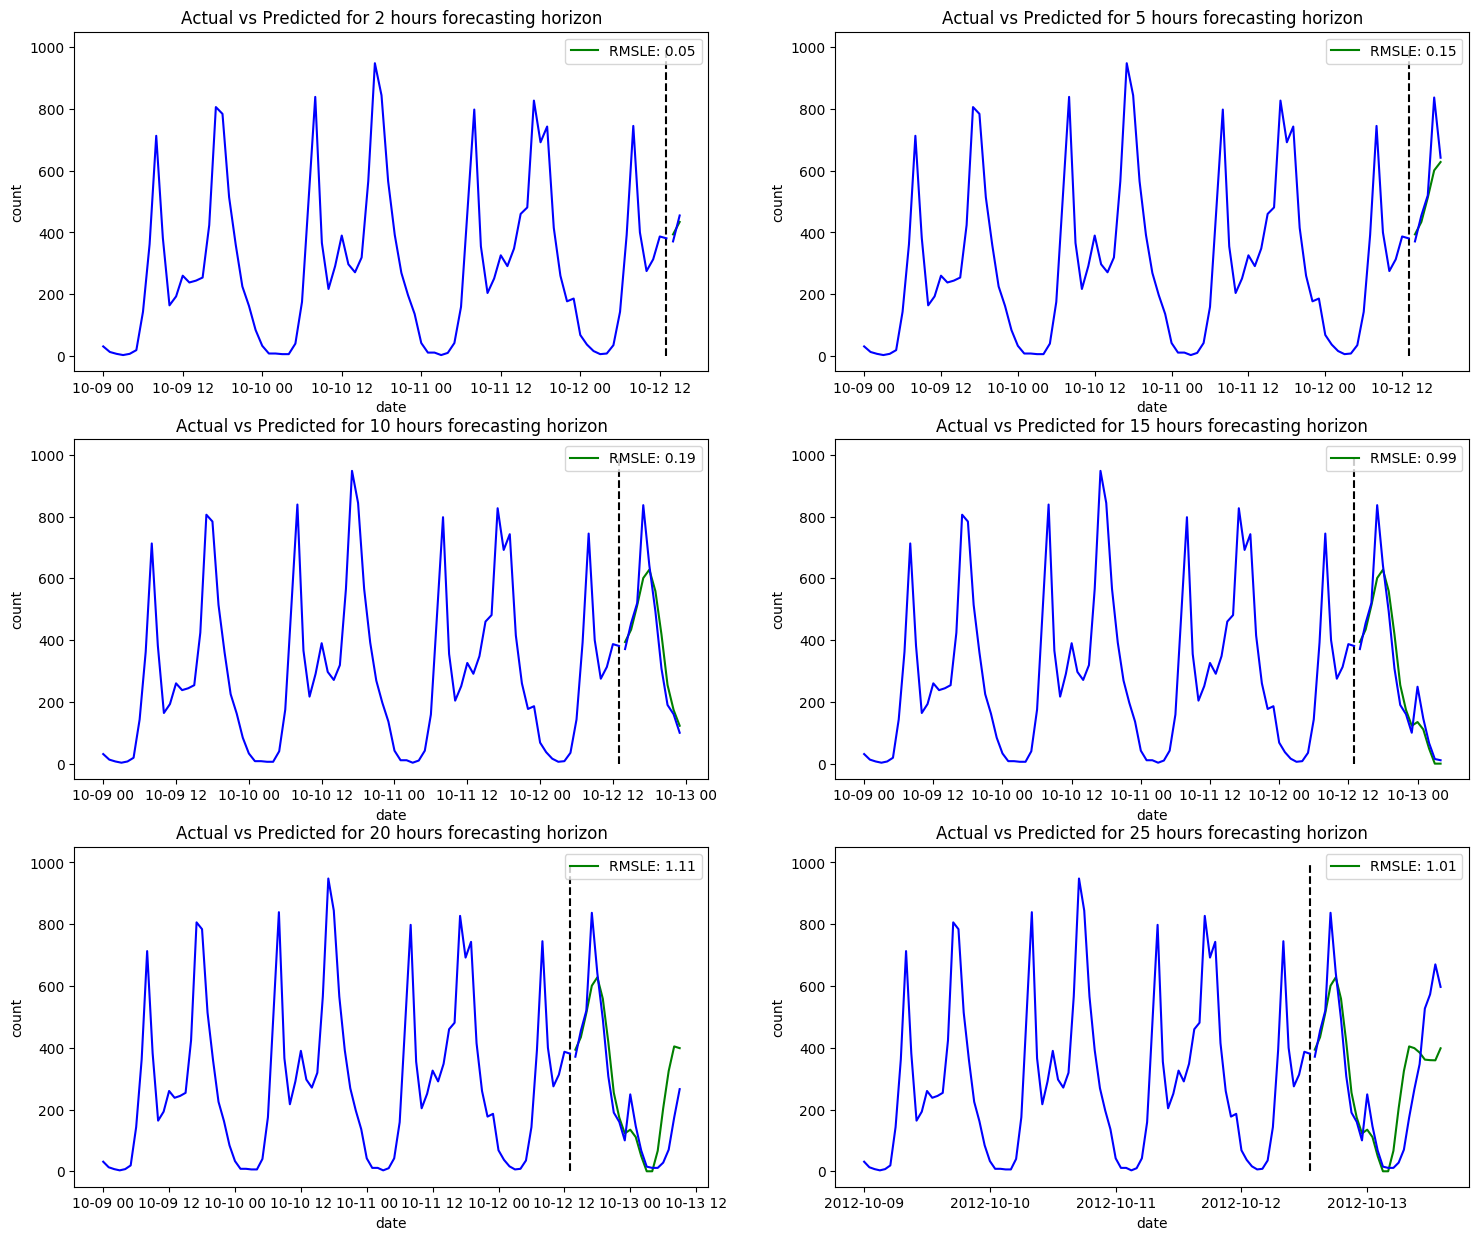

In [0]:
fig, ax_arr = plt.subplots(3,2, figsize=(18,15))
ax_arr = ax_arr.ravel()

for row, time_delta in enumerate([1, 4, 9, 14, 19, 24]):
  # make your forecasts
  forecasts = model.predict(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].reset_index().rename(columns={'datetime':'ds'}))  # predict N steps into the future
  forecasts[forecasts['yhat'] < 0] = 0
  rmsle = np.round(np.sqrt(mean_squared_log_error(forecasts['yhat'], X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit="h")]["count"])), 2)
  
  # Visualize the forecasts (blue=train, green=forecasts)
  ax_arr[row].plot(X_train['2012-10-09':].index, X_train['2012-10-09':]['count'], c='blue', label='_')
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index, forecasts['yhat'], c='green', label=f'RMSLE: {rmsle}')
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index, X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')]['count'], c='blue',     label='_')
  ax_arr[row].vlines(x=X_train.index[-1], ymin=0,ymax=1000, linestyles='dashed')
  ax_arr[row].title.set_text(f'Actual vs Predicted for {time_delta + 1} hours forecasting horizon')
  ax_arr[row].set_ylabel('count')
  ax_arr[row].set_xlabel('date')
  ax_arr[row].legend()

display(ax_arr[0])

A few point to make:
* After playing around with the different features that should be included, it was concluded that the features season, weather, workingday and holiday greatly decreased the accuracy of our model, so we ommitted them.
* The training time is extremely fast.
* A lot of hyperparameter tuning was involved. Like the ARIMA models, Prophet allows you to set most of the hyperparameters to `auto`, where the library will take care of finding the optimal hyperparameters. That being said, the seasonalities in our data weren't getting recognized by the model, so we were forced to set them ourselves. The same goes for the number of changepoints, where Prophet was adding way too many.
* Finally, and most importantly, it seems like Prophet doesn't perform much better than SARIMAX did. Just like SARIMAX, it seems to struggle once it gets past the ten hour forecasting horizon mark.

Another popular algorithm used for time series forecasting is LightGBM. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient, with the advantage of being fast, scalable, and accurate. We'll use the `LGBMRegressor` class to forecast, but before doing so, we need to preprocess our data in a way that it's understood by LightGBM. Namely, we'll:
1. Convert our data so that it can be viewed as a supervised learning problem. This is done by adding columns for observations at time *t-1*, *t-2*,..., *t-4*, and use these observation to predict demand at time *t*. Note that we could've looked further into the past e.g. t-10, but chose to stick with four time periods.
2. We standardize the data, as is assumed by LGBM.

In [0]:
# LGBM
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(X_train.drop(['season','holiday','workingday', 'weather'], axis=1))
scaled_test = scaler.transform(X_test.drop(['season','holiday','workingday', 'weather'], axis=1))

# frame as supervised learning
reframed_train = series_to_supervised(scaled_train, 4, 1)
reframed_test = series_to_supervised(scaled_test, 4, 1)

# split into input and outputs
values_train = reframed_train.values
train_X, train_y = values_train[:, :-1], values_train[:, -1]

values_test = reframed_test.values
test_X, test_y = values_test[:,:-1], values_test[:,-1]



model = lgb.LGBMRegressor(max_depth=15, num_leaves=100, min_data_in_leaf=400, num_iterations=500, learning_rate=0.1)
%time model.fit(train_X, train_y)

/databricks/python/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
 warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
CPU times: user 19.7 s, sys: 106 ms, total: 19.8 s
Wall time: 630 ms
Out[86]: LGBMRegressor(max_depth=15, min_data_in_leaf=400, num_iterations=500,
 num_leaves=100)

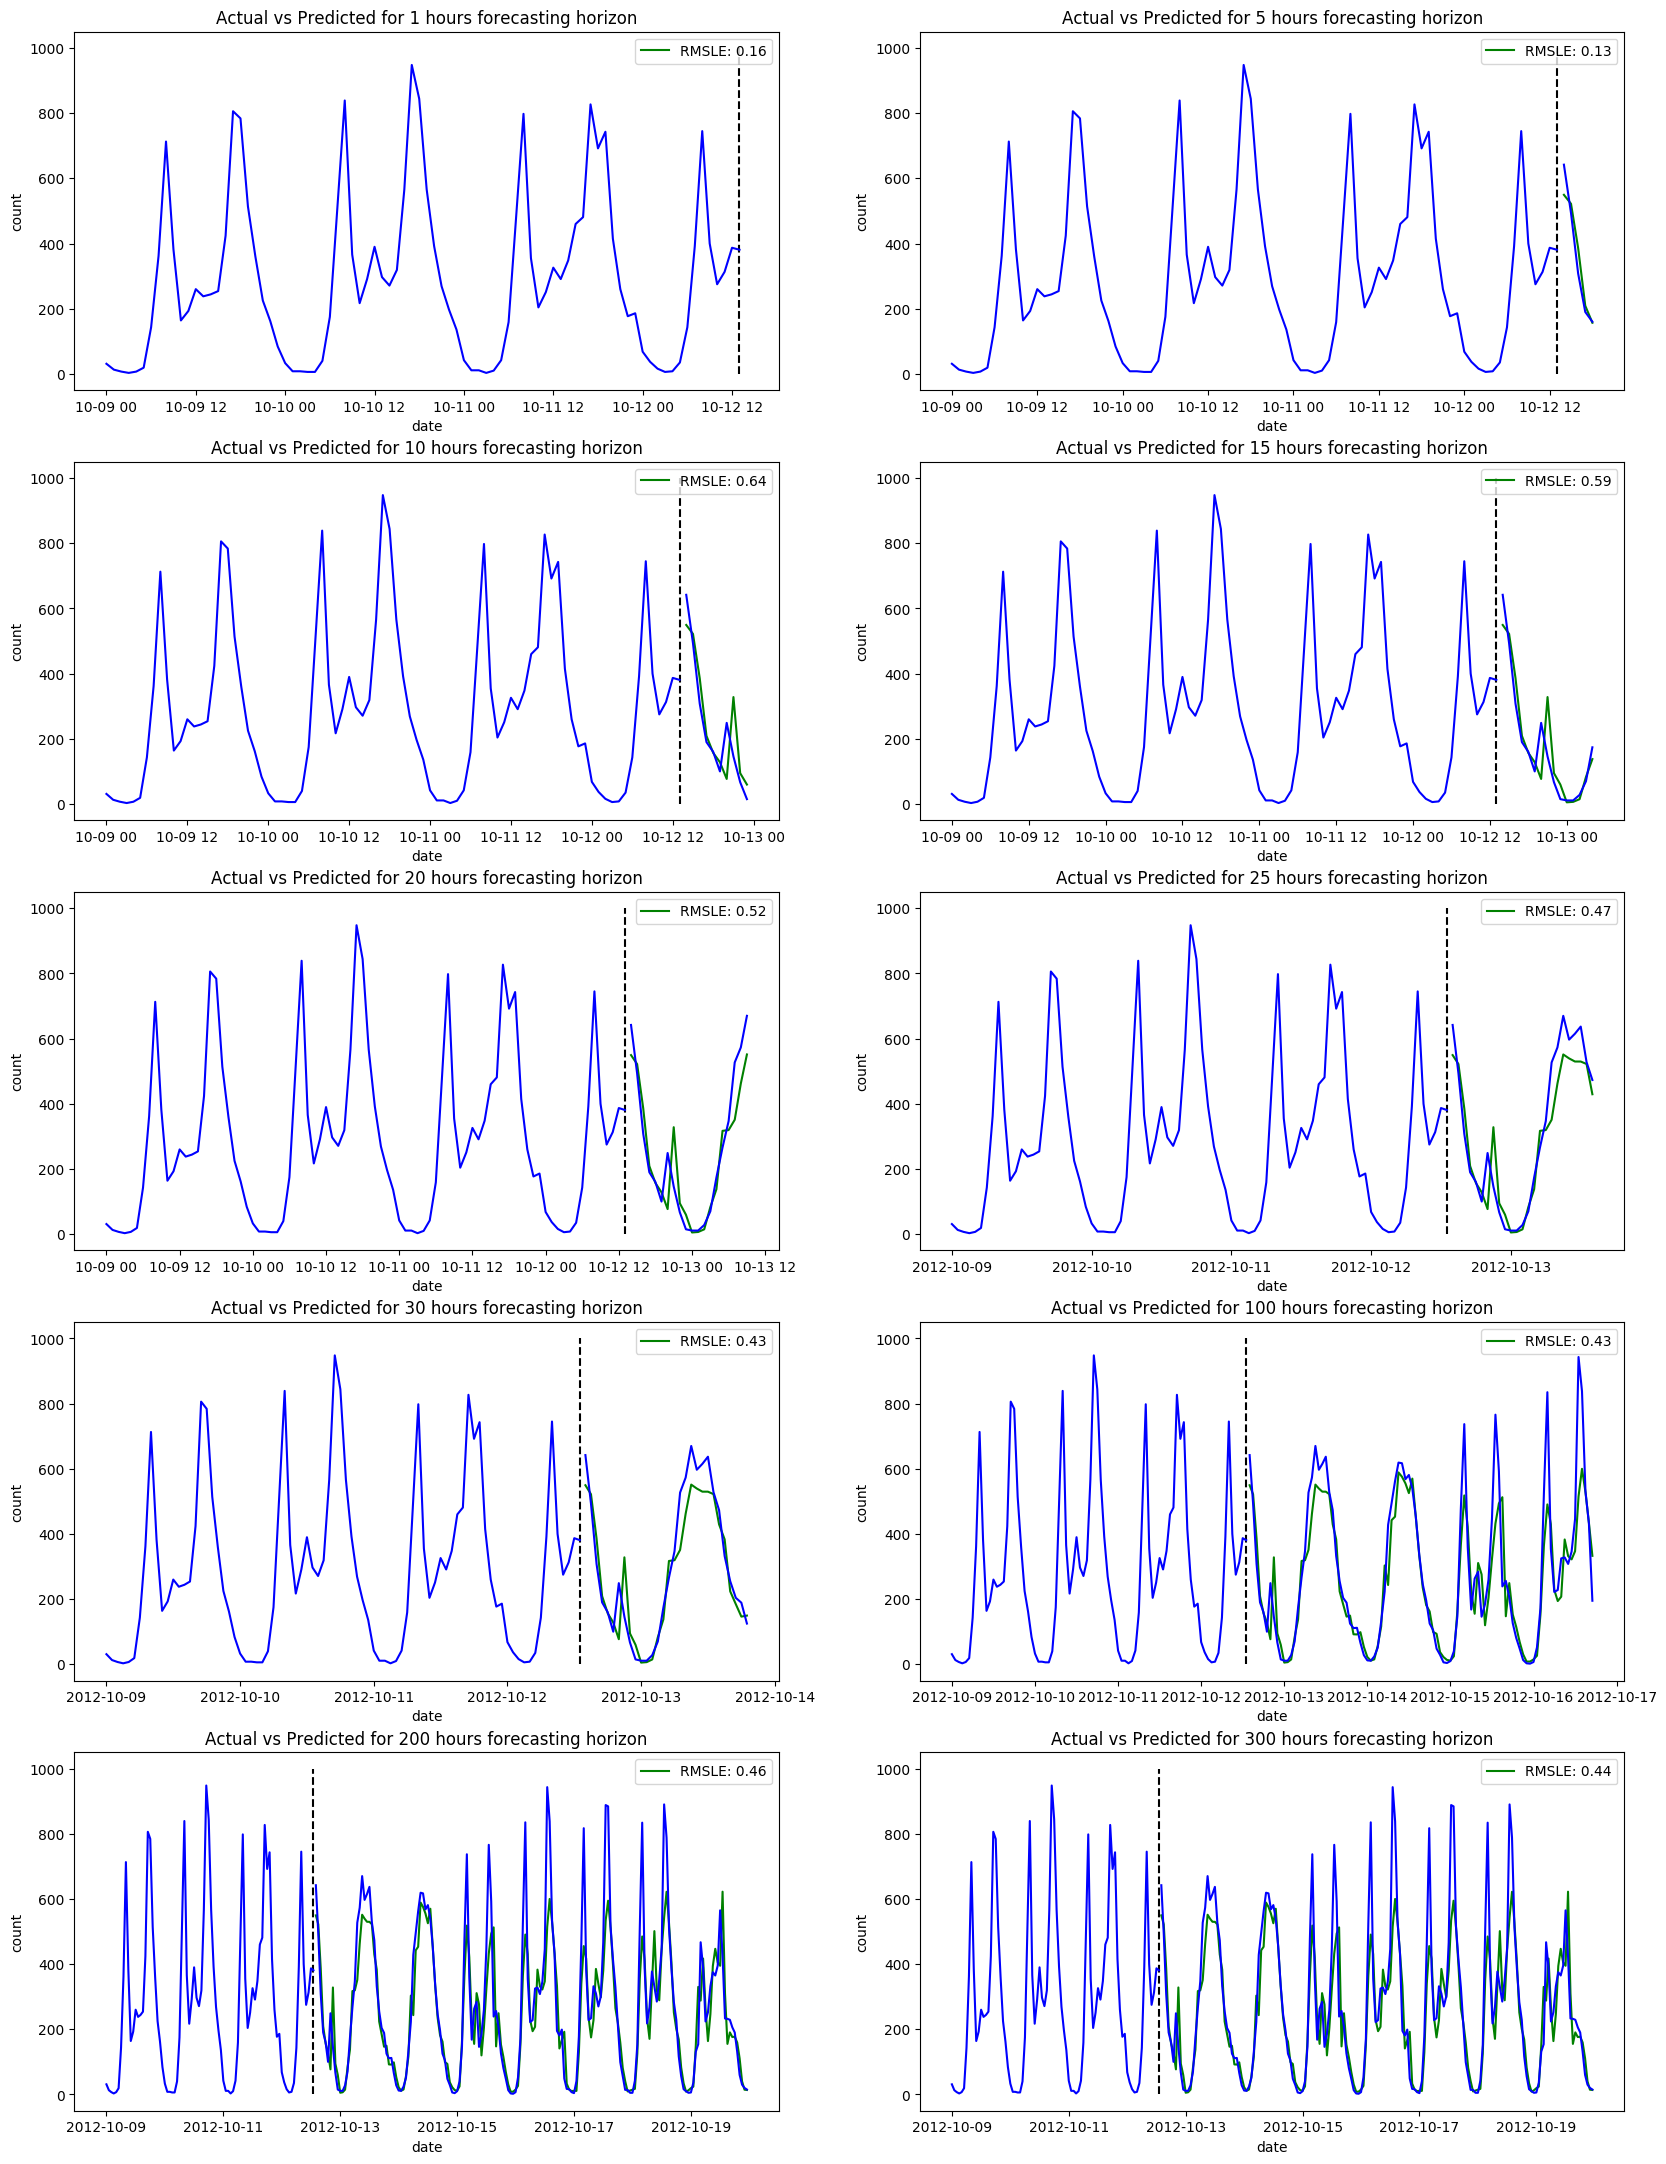

In [0]:
fig, ax_arr = plt.subplots(5,2, figsize=(20,27))
ax_arr = ax_arr.ravel()
test_X_original = test_X

for row, time_delta in enumerate([1, 5, 10, 15, 20, 25, 30, 100, 200, 300]):
  test_X = test_X_original[:time_delta]
  
  # make a prediction
  yhat = regressor.predict(test_X)
  yhat = np.reshape(yhat,(-1, 1))
  
  
   # invert scaling for forecast
  inv_yhat = np.concatenate((test_X[:, 20:], yhat), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,-1]
  
  # invert scaling for actual
  test_y = np.reshape(test_y,(-1, 1))
  inv_y = np.concatenate((test_X[:, 20:], test_y[:time_delta]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,-1]

  # calculate RMSLE
  rmsle = np.round(np.sqrt(mean_squared_log_error(inv_yhat, inv_y)), 2)

  
  # Visualize the forecasts (blue=train, green=forecasts)
  ax_arr[row].plot(X_train['2012-10-09':].index, X_train['2012-10-09':]['count'], c='blue', label='_')
  
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index[:time_delta], inv_yhat[:X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index[:time_delta].size], c='green', label=f'RMSLE: {rmsle}')
  
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index[:time_delta],inv_y[:X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index[:time_delta].size], c='blue', label='_')

  ax_arr[row].vlines(x=X_train.index[-1], ymin=0,ymax=1000, linestyles='dashed')
  ax_arr[row].title.set_text(f'Actual vs Predicted for {time_delta} hours forecasting horizon')
  ax_arr[row].set_ylabel('count')
  ax_arr[row].set_xlabel('date')
  ax_arr[row].legend()
  
display(ax_arr[0])

Very interesting results. Not only is the training time extremely low, but the RMSLE is also low for both short- and long-term forecasting. Of course, an error of 0.44 for a forecasting horizon of 300 hours isn’t great, but when compared to previous models, LGBM is well ahead. As for the number of hyperparameters, LightGBM has over 20 possible parameters that can be included. The ones we chose are claimed by LGBM’s documentation to be the most important. Selecting these parameters wasn’t difficult, we simply followed the suggestions in the documentation as to how we should set them, and obtained the results in the graphs above. Also note that the amount of data preparation needed so that it can be inputted to the network is significantly larger than it was for all the other models.

The final model we'll use to forecast is a type of recurrent neural network (RNN), the LSTM. The beauty behind RNNs is in their ability to maintain a memory. While feed-forward neural networks are great for tasks such as image classification, they're limited in their ability to process sequenced data. With no notion of time, feed forward neural networks aren't the best DL models for time series forecasting. RNNs, and LSTMs in specific, do consider the time and order in which data is presented, making them great candidates for time series forecasting.

The architecture we'll use is very basic, and includes:
1.	Three LSTM layers with 100 nodes each
2.	An output layer with four nodes and ReLU activation

We also preprocess our data in the same way we did for LGBM, to get our data ready to be used by an LSTM.

In [0]:
# This code was taken from Jason Brownlee's blog post on Multivariate Time Series Forecasting With LSTMs in Keras (https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/), and adapted to suit our needs.
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(X_train.drop(['season','holiday','workingday', 'weather'], axis=1))
scaled_test = scaler.transform(X_test.drop(['season','holiday','workingday', 'weather'], axis=1))

# frame as supervised learning
reframed_train = series_to_supervised(scaled_train, 4, 1)
reframed_test = series_to_supervised(scaled_test, 4, 1)

# split into input and outputs
values_train = reframed_train.values
train_X, train_y = values_train[:, :-1], values_train[:, -1]

values_test = reframed_test.values
test_X, test_y = values_test[:,:-1], values_test[:,-1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='relu'))
model.compile(loss='mae', optimizer='adam')

# fit network
%time model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

CPU times: user 3min 29s, sys: 1min 41s, total: 5min 11s
Wall time: 1min 6s
Out[187]: <keras.callbacks.History at 0x7f107b712550>

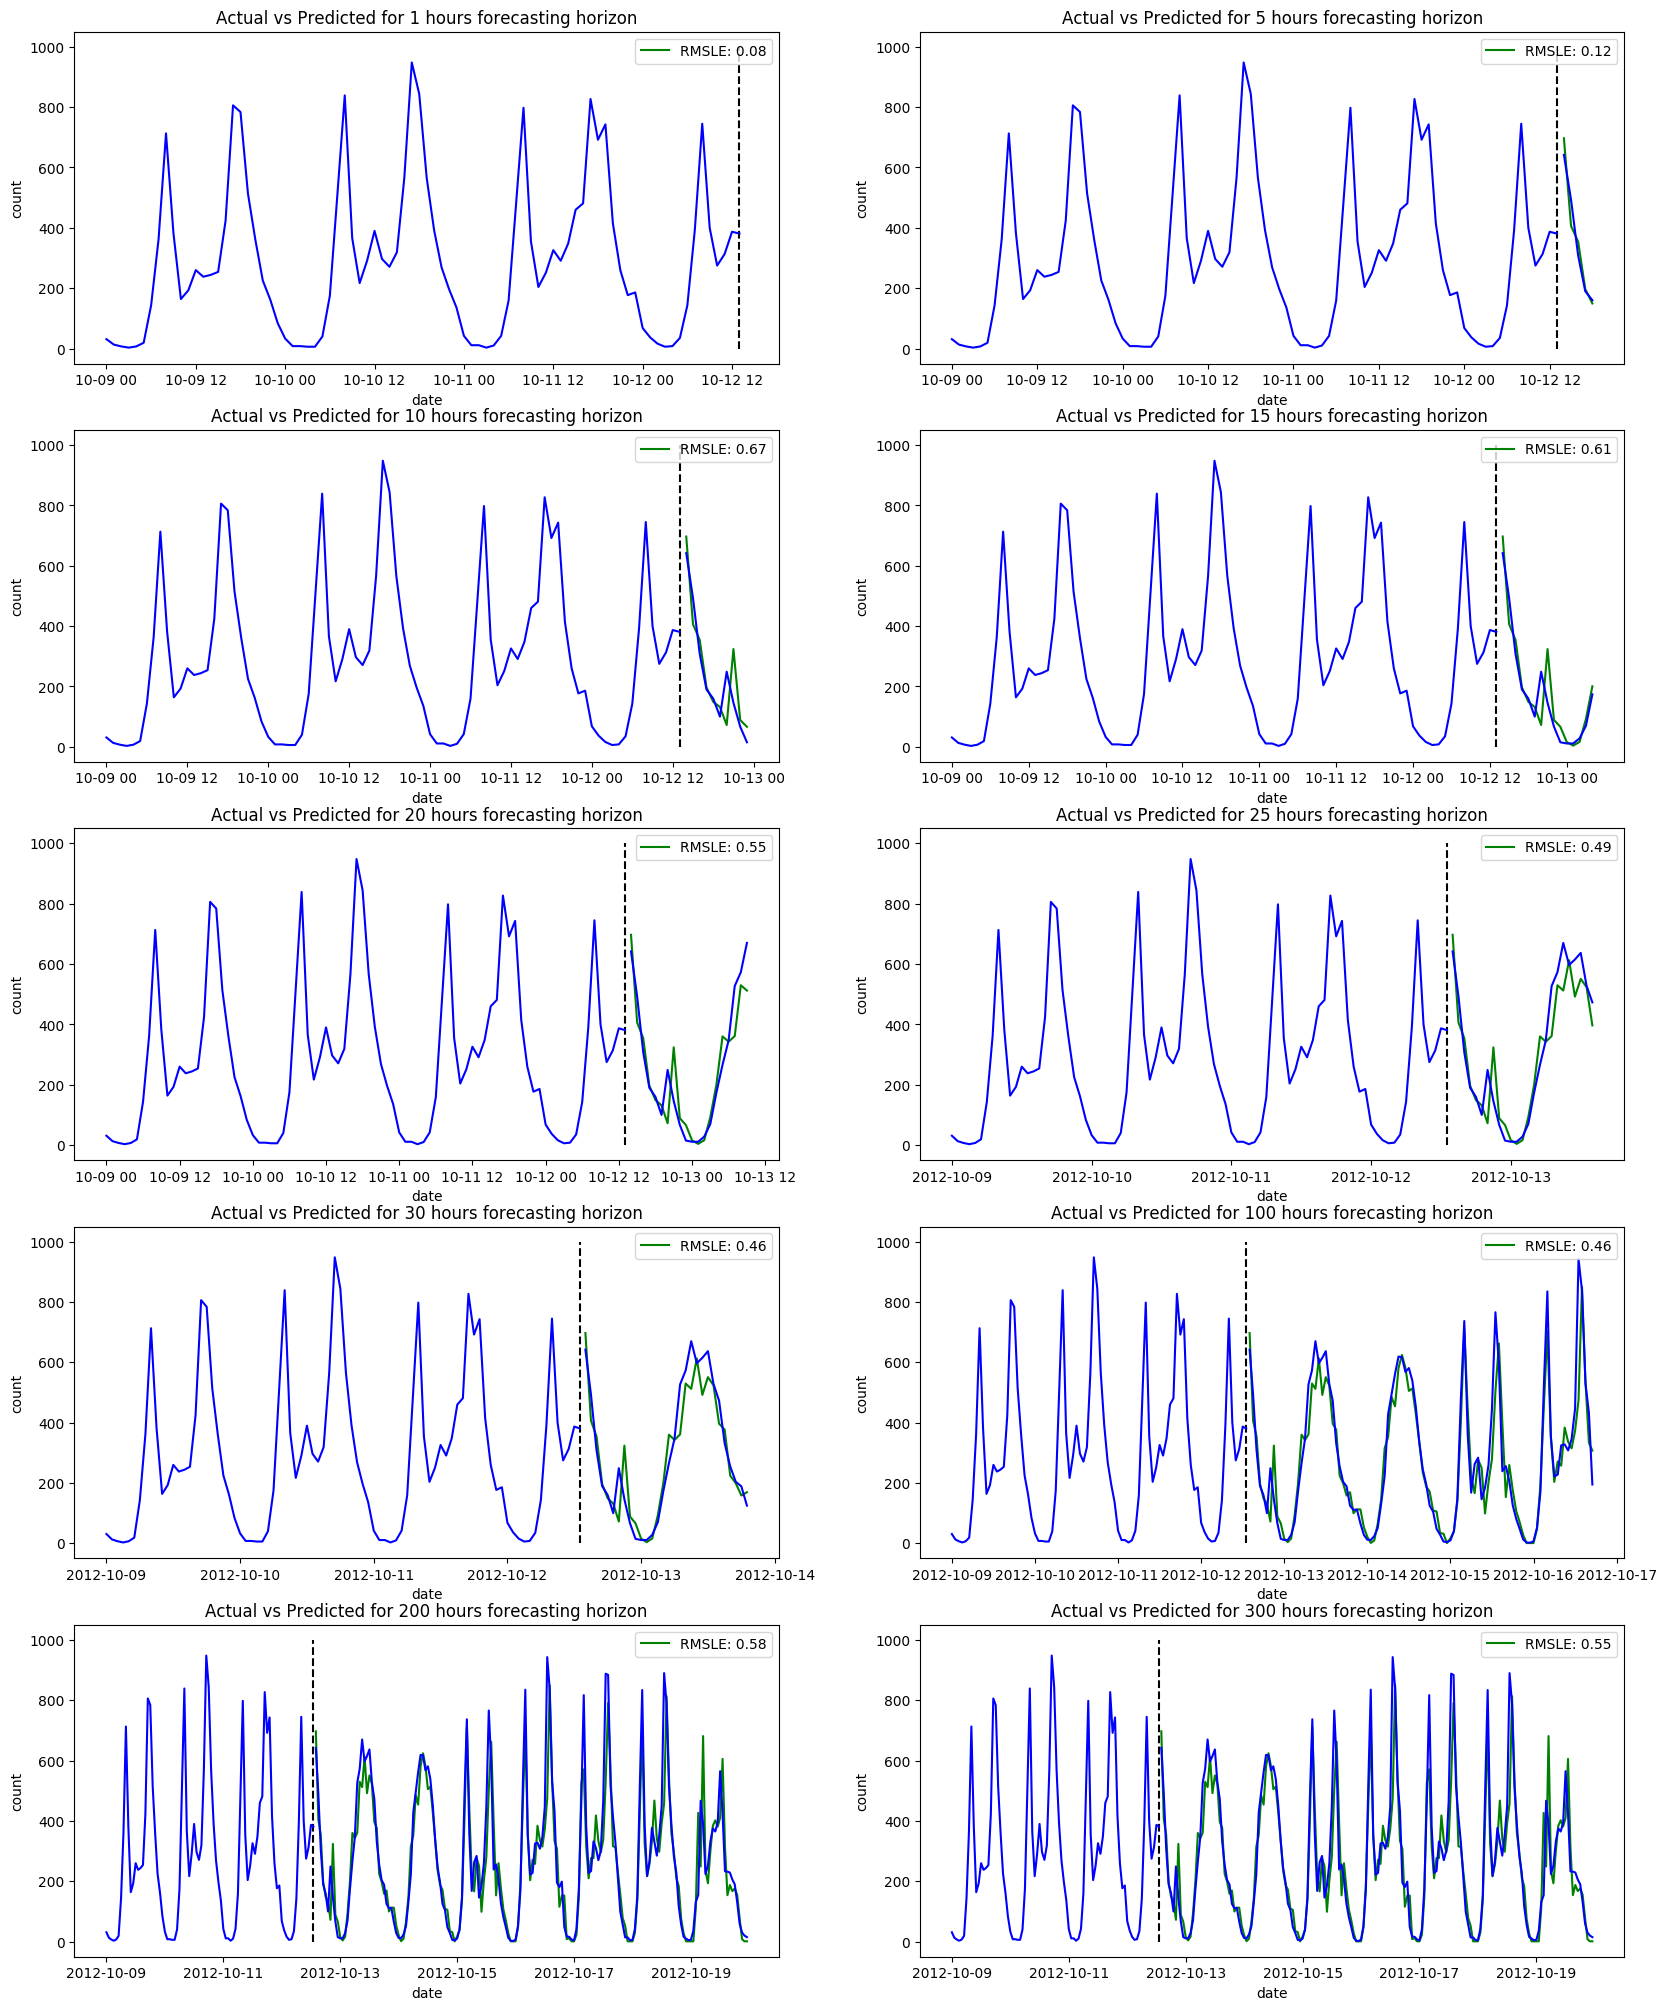

In [0]:
fig, ax_arr = plt.subplots(5,2, figsize=(20,25))
ax_arr = ax_arr.ravel()
test_X_original = test_X
for row, time_delta in enumerate([1, 5, 10, 15, 20, 25, 30, 100, 200, 300]):

  test_X = test_X_original[:time_delta]

  # make a prediction
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

  # invert scaling for forecast
  inv_yhat = np.concatenate((test_X[:, 20:], yhat), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,-1]

  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((test_X[:, 20:], test_y[:time_delta]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,-1]
  # calculate RMSE
  rmsle =  np.round(np.sqrt(mean_squared_log_error(inv_y, inv_yhat)), 2)
  
  # Visualize the forecasts (blue=train, green=forecasts)
  ax_arr[row].plot(X_train['2012-10-09':].index, X_train['2012-10-09':]['count'], c='blue', label='_')
  
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index[:time_delta], inv_yhat[:X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index[:time_delta].size], c='green', label=f'RMSLE: {rmsle}')
  
  ax_arr[row].plot(X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index[:time_delta],inv_y[:X_test[:X_test.index[0] + pd.Timedelta(value=time_delta, unit='h')].index[:time_delta].size], c='blue', label='_')

  ax_arr[row].vlines(x=X_train.index[-1], ymin=0,ymax=1000, linestyles='dashed')
  ax_arr[row].title.set_text(f'Actual vs Predicted for {time_delta} hours forecasting horizon')
  ax_arr[row].set_ylabel('count')
  ax_arr[row].set_xlabel('date')
  ax_arr[row].legend()
  
display(ax_arr[0])

Interesting results. The training time is low, standing at a minute, and the LSTM seems to get lower forecasting errors for both low- and long-term forecasts. Although the RMSLE values for larger forecasting horizons are still high, if compared to both the best results obtained from the competition, and the results of other models, they're pretty good. Also note that the amount of data preparation needed so that it can be inputed to the network is significantly larger than it was for all the other models.

## Conclusion

Now, to answer the question: is deep learning needed for time series forecasting? Of course, Your decision should be based on your business's objectives, resources, and expertise. However, opposite to the current trend seen in both academia and industry, deep learning isn’t always the solution. For the bike sharing demand dataset, we saw that LightGBM performed much better than the LSTM. While deep models have become easier to create and use, they still come with their fair share of complexity. As your dataset becomes more complicated, so will your neural network, leading to problems with scalability, explainability and efficiency.

As for the autoregressive models, they were good for short term forecasting, but struggled as we increased the forecasting horizon. More complicated models in SARIMA and SARIMAX came at the cost of a higher training time, with little benefit to the forecasting accuracy. They also involve more parameters, which implies the need for better statistical knowledge. Prophet's training time was significantly better than that of SARIMAX, with similar forecasting results, so it can be used as an alternative to SARIMAX. This doesn't mean, however, that the likes of ARIMA, SARIMA and SARIMAX should be completely ignored. For smaller datasets, that aren't too complex, these autoregressive models can be very useful.

I leave you with the table below, which summarizes the results we got in this article.

|   Model  | Training Time |                                                                                  Pros                                                                                  |                                                                                                   Cons                                                                                                   |
|:--------:|:-------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
|   ARIMA  |      20s      | Fast training time <br> <br>   Good for short-term forecasts <br><br>  Many hyperparameters but their are libraries that can help automate the selection               | Bad for long term forecasts <br><br>  Doesn't consider seasonality <br><br>  If automated hyperparameter tuning doesn't work, will require input from an expert                                          |
|  SARIMA  |      21m      | Considers seasonalities                                                                                                                                                | Slow training time <br><br>  Seven parameters that need to be tuned properly <br><br>                                                                                                                    |
|  SARIMAX |     1h20m     | Allows for more features to be included in the model                                                                                                                   | Slow training time for not much of a reward <br><br>  Seven parameters that need to be tuned properly                                                                                                    |
|  Prophet |     500ms     | Fast training time                                                                                                                                                     | Automated hyperparameter tuning doesn't always work <br><br>  Many parameters that need to be tuned, requiring expert advice                                                                             |
| LightGBM |     630ms     | Fast Training Time <br><br>  Lowest forecasting errors for both short- and long-term forecasting horizons <br><br>  Clear rules on how to set baseline hyperparameters | Logic needed to be compatible with time series data <br><br>  More than twenty possible hyperparameters that can be tuned                                                                                |
|   LSTM   |      20s      | Fast training time for small dataset and simple architecture <br><br>   Good for both short and long term forecasts                                                    | Logic needed to be compatible with time series data <br><br>  More complex architecture to understand <br><br>  Prone to overfitting <br><br>  Hard to get optimal architecture, lots of trial and error |

## References

1. https://peerj.com/preprints/3190/
2. https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/